# Supply Chain Example

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import torch
import lropt
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

In [2]:
np.random.seed(0)

# generate problem data
n = 4   # nodes
k = 2   # suppliers (with prices p)
c = 2   # retail (with demand d)
m = 8   # links

supply_links = [0, 1]
retail_links = [6, 7]
internode_links = [2, 3, 4, 5]

# Incidence matrices (nodes x links)
A_in = np.array([[1, 0, 0, 0, 0, 0, 0, 0],   # 1 (supply)
                 [0, 1, 0, 0, 0, 0, 0, 0],   # 2 (supply)
                 [0, 0, 1, 0, 0, 1, 0, 0],   # 3 (retail)
                 [0, 0, 0, 1, 1, 0, 0, 0],   # 4 (retail)
                 ])

A_out = np.array([[0, 0, 1, 1, 0, 0, 0, 0],   # 1 (supply)
                  [0, 0, 0, 0, 1, 0, 0, 0],   # 2 (supply)
                  [0, 0, 0, 0, 0, 0, 1, 0],   # 3 (retail)
                  [0, 0, 0, 0, 0, 1, 0, 1],   # 4 (retail)
                  ])

# Prices
mu_p = torch.tensor([0, 0.1]).double()
sigma_p = torch.tensor([0.2, 0.2]).double()
mean_p = torch.exp(mu_p + sigma_p ** 2 /2).double().view(k, 1)
var_p = (torch.exp(sigma_p ** 2) - 1) * torch.exp(2 * mean_p + sigma_p ** 2)

# Demands
mu_d = torch.tensor([0.0, 0.4]).double()
sigma_d = torch.tensor([0.2, 0.2]).double()
mean_d = torch.exp(mu_d + sigma_d ** 2 /2).double().view(c, 1)
var_d = (torch.exp(sigma_d ** 2) - 1) * torch.exp(2 * mean_d + sigma_d ** 2)

# Uncertainty distribution (prices and demands)
w_dist = torch.distributions.log_normal.LogNormal(torch.cat([mu_p, mu_d], 0), 
                                                  torch.cat([sigma_p, sigma_d], 0))

# Capacities
h_max = 3. # Maximum capacity in every node
u_max = 2. # Link flow capacity

# Storage cost parameters, W(x) = alpha'x + beta'x^2 + gamma
alpha = 0.01
beta = 0.01

# Transportation cost parameters
tau = 0.05 * np.ones((m - k - c,1))
tau_th = torch.tensor(tau, dtype=torch.double)
r = 1.3 * np.ones((k,1))
r_th = torch.tensor(r, dtype=torch.double)

In [3]:
init_size = 100
# Define linear dynamics
# x = (h, p^{wh}, d) 
# u = u
# w = (p^{wh}, d)
# x_{t+1} = Ax_{t} + Bu_{t} + w
A_d = np.bmat([[np.eye(n), np.zeros((n, k+c))],
              [np.zeros((k+c, n)), np.zeros((k+c, k+c))]])
A_d_th = torch.tensor(A_d, dtype=torch.double)
B_d = np.vstack([A_in - A_out,
                 np.zeros((k+c, m))])
B_d_th = torch.tensor(B_d, dtype=torch.double)
n_x, n_u = B_d.shape

# Setup policy
# Parameters
P_sqrt = cp.Parameter((n, n))
q = cp.Parameter((n, 1))
x = lropt.Parameter((n_x,1), data=np.zeros((init_size,n_x,1)))
d = lropt.UncertainParameter(c,uncertainty_set = lropt.Ellipsoidal(rho=1,data=np.zeros((init_size,c))))
h, p, d_unneeded = x[:n], x[n:n+k], x[(n+k):]

# Variables
u = cp.Variable((n_u,1))
h_next = cp.Variable((n,1))

# Cvxpy Layer
stage_cost = cp.vstack([p, tau, -r]).T @ u + cp.sum_squares(h_next) -3*np.ones(n)@h_next

# next_stage_cost = cp.sum_squares(P_sqrt @ h_next) + q.T @ h_next
constraints = [h_next == h + (A_in - A_out) @ u, 
               h_next <= h_max,  
               0 <= u, u <= u_max,
               A_out @ u <= h, u[retail_links].flatten()  <= d,
              ]
prob = lropt.RobustProblem(cp.Minimize(stage_cost), constraints)
trainer = lropt.Trainer(prob)
policy = trainer.create_cvxpylayer(variables = [u])

In [4]:
class SupplyChainSimulator(lropt.Simulator):
  def simulate(self,x,u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    A_batch = A_d_th.repeat(batch_size, 1, 1)
    B_batch = B_d_th.repeat(batch_size, 1, 1)
    
    zer = torch.zeros(batch_size, n, 1).double()
    w = w_dist.sample((batch_size,)).double().view((batch_size, k + c, 1))
    w_batch = torch.cat([zer, w], 1).double()
    
    return torch.bmm(A_batch, x) + torch.bmm(B_batch, u) + w_batch

  def stage_cost(self,x,u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    r_batch = r_th.repeat(batch_size, 1, 1)
    tau_batch = tau_th.repeat(batch_size, 1, 1)
    h, p, dh = x[:,:n], x[:, n:n+k], x[:, n+k:]
    s_vec = torch.cat([p, tau_batch, -r_batch], 1).double()
    S = torch.bmm(s_vec.transpose(1, 2), u)
    H = alpha * h + beta * (h ** 2)
    return torch.sum(S, 1) + torch.sum(H, 1)

  def constraint_cost(self,x,u,alpha):
    eta = 0.05
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    h, p, dh = x[:,:n], x[:, n:n+k], x[:, n+k:]
    cvar_term =(1/eta)*(torch.max(torch.max(u[:,retail_links,:] - dh,axis=1)[0] - alpha,torch.zeros(batch_size))[0]) + alpha
    return 0.01*cvar_term

  def init_state(self,batch_size, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    x_b_0 = h_max * torch.rand(batch_size, n, 1).double()
    w_0 = w_dist.sample((batch_size,)).double().view((batch_size, k+c, 1))
    x_batch = torch.cat([x_b_0, w_0], 1).double()
    return x_batch
  
simulator = SupplyChainSimulator()

In [5]:
# Perform training
time_horizon = 20
epochs = 50
batch_size = 10
trials = 1
lr = 0.8
init_x = simulator.init_state(seed = 0, batch_size = 100)
_,_, init_dh = init_x[:,:n], init_x[:, n:n+k], init_x[:, n+k:]
init_dh = torch.flatten(init_dh, start_dim = 1)
init_a = torch.tensor(sc.linalg.sqrtm(np.cov(init_dh.detach().numpy().T)),dtype=torch.double)
init_b = torch.mean(init_dh,axis=0)

val_costs, val_costs_constr, \
  paramvals, x_base, u_base = trainer.multistage_train(simulator, 
                                                       policy = policy, 
                         time_horizon = time_horizon, epochs = epochs, 
                         batch_size = batch_size,
                         trials = trials, init_eps=1, seed=0,
                          init_a = init_a, init_b = init_b,
                          optimizer = "SGD",lr= lr, momentum = 0, init_alpha = 0.0, scheduler = False)

Baseline cost:  -0.2652498833625534
epoch 0, valid -2.6525e-01
epoch 1, valid -2.7628e-01
epoch 2, valid -2.7698e-01
epoch 3, valid -2.7711e-01
epoch 4, valid -2.7664e-01
epoch 5, valid -2.7846e-01
epoch 6, valid -2.7918e-01
epoch 7, valid -2.7951e-01
epoch 8, valid -2.8006e-01
epoch 9, valid -2.7964e-01
epoch 10, valid -2.7974e-01
epoch 11, valid -2.7994e-01
epoch 12, valid -2.8003e-01
epoch 13, valid -2.8014e-01
epoch 14, valid -2.8014e-01
epoch 15, valid -2.8014e-01
epoch 16, valid -2.8012e-01
epoch 17, valid -2.7996e-01
epoch 18, valid -2.7996e-01
epoch 19, valid -2.7996e-01
epoch 20, valid -2.8004e-01
epoch 21, valid -2.8012e-01
epoch 22, valid -2.8014e-01
epoch 23, valid -2.8014e-01
epoch 24, valid -2.8014e-01
epoch 25, valid -2.8012e-01
epoch 26, valid -2.8012e-01
epoch 27, valid -2.8012e-01
epoch 28, valid -2.8004e-01
epoch 29, valid -2.7996e-01
epoch 30, valid -2.7988e-01
epoch 31, valid -2.7980e-01
epoch 32, valid -2.7980e-01
epoch 33, valid -2.7988e-01
epoch 34, valid -2.798

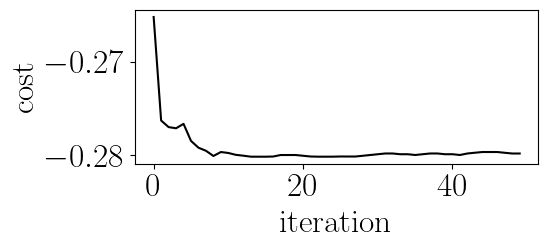

In [6]:
plt.figure(figsize=(6, 3))
plt.plot(np.array(val_costs) +np.array(val_costs_constr), c='k', label="Loss")
plt.xlabel('iteration')
plt.ylabel('cost')
plt.tight_layout()
plt.show()

### Old code not using package class

In [7]:
rho_mult_tch = trainer.gen_rho_mult_tch(trainer._rho_mult_parameter)

def simulate(x, u):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    # u = u.double().view((batch_size, n_u, 1))

    A_batch = A_d_th.repeat(batch_size, 1, 1)
    B_batch = B_d_th.repeat(batch_size, 1, 1)
    
    zer = torch.zeros(batch_size, n, 1).double()
    w = w_dist.sample((batch_size,)).double().view((batch_size, k + c, 1))
    w_batch = torch.cat([zer, w], 1).double()
    
    return torch.bmm(A_batch, x) + torch.bmm(B_batch, u) + w_batch


def stage_cost(x, u,alpha_cvar,eta):
    assert x.shape[0] == u.shape[0]
    batch_size = x.shape[0]
    # u = u.double().view((batch_size, n_u, 1))
    r_batch = r_th.repeat(batch_size, 1, 1)
    tau_batch = tau_th.repeat(batch_size, 1, 1)
    # h_tch = x[:,:n,:].double().view((batch_size,n))
    # p_tch = x[:,n:n+k,:].double().view((batch_size,k))
    # d_tch = x[:,n+k:,:].double().view((batch_size,c,1))
    h, p, dh = x[:,:n], x[:, n:n+k], x[:, n+k:]

    # Selling + buying + shipping cost
    s_vec = torch.cat([p, tau_batch, -r_batch], 1).double()
    S = torch.bmm(s_vec.transpose(1, 2), u)
    H = alpha * h + beta * (h ** 2)

    cvar_term =(1/eta)*(torch.max(torch.max(u[:,retail_links,:] - dh,axis=1)[0] - alpha_cvar,torch.zeros(batch_size))[0]) + alpha_cvar
    return torch.sum(S, 1) + torch.sum(H, 1) + 0.01*cvar_term

In [8]:
def loss(policy, time_horizon, kwargs,alpha_cvar,eta, batch_size=1, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        
    # Batchify input
    x_b_0 = h_max * torch.rand(batch_size, n, 1).double()
    w_0 = w_dist.sample((batch_size,)).double().view((batch_size, k+c, 1))
    x_batch = torch.cat([x_b_0, w_0], 1).double()

    a_tch, b_tch = trainer.create_tensors_linear(
       [x_batch],
        kwargs['model'])

    cost = 0.0
    x_t = x_batch
    x_hist = [x_batch]
    u_hist = []
    for t in range(time_horizon):
        u_t = policy(rho_mult_tch.repeat(batch_size), x_t,a_tch,b_tch)[0]
        x_t = simulate(x_t, u_t) 
        cost += stage_cost(x_t, u_t,alpha_cvar,eta).mean() / time_horizon
        x_hist.append(x_t)
        u_hist.append(u_t)
        # h_tch = x_t[:,:n,:].double().view((batch_size,n))
        # p_tch = x_t[:,n:n+k,:].double().view((batch_size,k))
        a_tch, b_tch = trainer.create_tensors_linear(
        [x_t],
        kwargs['model'])
    return cost, x_hist, u_hist

In [9]:
def monte_carlo(policy, time_horizon, kwargs,alpha_cvar,eta, batch_size=1, trials=10, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    results = []
    x = []
    u = []
    
    for i in range(trials):
        cost, x_hist, u_hist = loss(policy, time_horizon, kwargs,alpha_cvar,eta, batch_size=batch_size, seed=seed)
        results.append(cost.item())
        x.append(x_hist)
        u.append(u_hist)
    return results, x, u

def train(policy, params, time_horizon, lr, epochs, batch_size,kwargs,alpha_cvar,eta):
    opt = torch.optim.SGD(params, lr=lr)
    val_costs = []
    best_params = []
            
    for epoch in range(epochs):
        with torch.no_grad():
            val_cost_mc, x_behav, u_behav = monte_carlo(policy, time_horizon, kwargs,alpha_cvar,eta,  1, trials=1, seed=0)
            val_cost = np.mean(val_cost_mc)
            val_costs.append(val_cost)

        torch.manual_seed(epoch)
        opt.zero_grad()
        cost, _, _,  = loss(policy, time_horizon, kwargs,alpha_cvar,eta, batch_size, seed=epoch+1)
        cost.backward()
        print("epoch %d, valid %.4e" % (epoch, val_cost))         
        # TODO: Print gradient norm (possibly clip it)
        # torch.nn.utils.clip_grad_norm_(params, 1)
#         for p in params:
#             print(p.grad.data.norm(2).item())
        opt.step()
#         scheduler.step(val_cost)        
    return val_costs, [np.array(p.detach().numpy()) for p in params], x_behav, u_behav

In [10]:
# setup linear model
alpha_cvar = torch.tensor(0.0,dtype=torch.double,requires_grad=True)
eta = 0.05
x_b_0 = h_max * torch.rand(init_size, n, 1).double()
w_0 = w_dist.sample((init_size,)).double().view((init_size, k+c, 1))
x_batch = torch.cat([x_b_0, w_0], 1).double()
# rho_tch = rho_mult_tch[0].repeat(batch_size,1)
h_tch = x_batch[:,:n,:].double().view((init_size,n))
p_tch = x_batch[:,n:n+k,:]
d_tch = x_batch[:,n+k:,:].double().view((init_size,c))
a_tch = torch.tensor(sc.linalg.sqrtm(np.cov(d_tch.detach().numpy().T)),dtype=torch.double)
b_tch = torch.mean(d_tch,axis=0)
kwargs = {}
kwargs['init_bias'] = None
kwargs['init_weight'] = None
kwargs['random_init'] = False
kwargs['seed'] = 0
kwargs['unc_set'] = d.uncertainty_set
kwargs['linear'] = trainer.init_linear_model(a_tch, b_tch)
kwargs['model'] = torch.nn.Sequential(kwargs['linear'])

# Perform training
time_horizon = 20
epochs = 50
batch_size = 10
lr = 0.8

# Initialize value function V(x) = x'Px + q'x
# centered at h_max/2 (between 0 and h_max) of each node
torch.manual_seed(0)
# P_sqrt = torch.zeros(n, n).double()
# q = torch.zeros((n, 1)).double()
params = [rho_mult_tch,alpha_cvar]
#params = []
params.extend(list(kwargs['model'].parameters()))

# Initial values 
print("Initial model weights: ",kwargs['linear'].weight.data)
print("Initial model bias: ",kwargs['linear'].bias.data)
print("Initial epsilon: ",rho_mult_tch)

# Baseline
baseline_costs, x_behav_bl, u_behav_bl = monte_carlo(policy, time_horizon, kwargs,alpha_cvar,eta, batch_size=1, trials=1, seed=0)
baseline_cost = np.mean(baseline_costs)
print("Baseline cost: ", baseline_cost)

print("Perform training")
val_cost, params, x_behav, u_behav = train(policy, params, time_horizon, lr, epochs, batch_size,kwargs,alpha_cvar,eta)
print("Final cost: ", val_cost[-1])

improvement = 100 * (baseline_cost - val_cost[-1])/np.abs(baseline_cost)
print("Performance improvement: %.2f %% over baseline cost" %  improvement)

# Store final values
print("Final model weights: ",kwargs['linear'].weight.data)
print("Final model bias: ",kwargs['linear'].bias.data)
print("Final epsilon: ",rho_mult_tch)

Initial model weights:  tensor([[0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]],
       dtype=torch.float64)
Initial model bias:  tensor([ 0.1988, -0.0210, -0.0210,  0.2926,  1.0067,  1.5195],
       dtype=torch.float64)
Initial epsilon:  tensor(1., dtype=torch.float64, requires_grad=True)
Baseline cost:  -0.264409531874021
Perform training
epoch 0, valid -2.6441e-01
epoch 1, valid -2.7520e-01
epoch 2, valid -2.7660e-01
epoch 3, valid -2.7598e-01
epoch 4, valid -2.7556e-01
epoch 5, valid -2.7764e-01
epoch 6, valid -2.7827e-01
epoch 7, valid -2.7874e-01
epoch 8, valid -2.7900e-01
epoch 9, valid -2.7906e-01

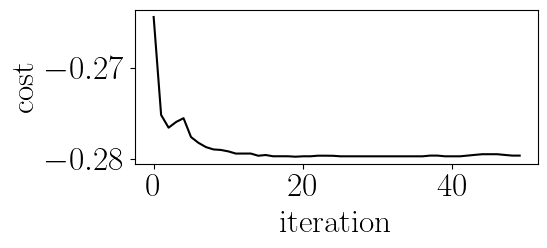

In [11]:
plt.figure(figsize=(6, 3))
plt.plot(val_cost, c='k', label="Loss")
plt.xlabel('iteration')
plt.ylabel('cost')
plt.tight_layout()
# plt.savefig("supply_chain_training.pdf")
plt.show()